Polygon points: [(470, 106), (628, 94)]
Polygon points: [(470, 106), (628, 94), (780, 628)]
Polygon points: [(470, 106), (628, 94), (780, 628), (458, 614)]
Saved polygon coordinates: [[470 106]
 [628  94]
 [780 628]
 [458 614]]


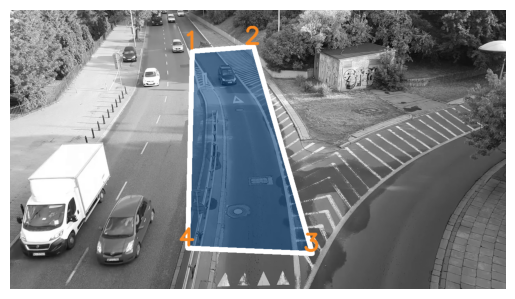

In [1]:
import cv2
import numpy as np
import supervision as sv
import matplotlib.pyplot as plt

clicked_points = []

def mouse_callback(event, x, y, flags, param):
    global clicked_points, img_copy
    
    if event == cv2.EVENT_LBUTTONDOWN:
        clicked_points.append((x, y))
        
        cv2.circle(img_copy, (x, y), 5, (0, 0, 255), -1) 
        cv2.putText(img_copy, f"({x},{y})", (x + 5, y - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 0), 2)

        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-2], clicked_points[-1], (0, 255, 0), 2)  

        if len(clicked_points) > 1:
            cv2.line(img_copy, clicked_points[-1], clicked_points[0], (0, 255, 0), 2) 
            print("Polygon points:", clicked_points)
            
            color1 = sv.Color.from_hex("#004080")
            color2 = sv.Color.from_hex("#f78923")
            img_copy = sv.draw_filled_polygon(img_copy, np.array(clicked_points), color1, 0.5)
            img_copy = sv.draw_polygon(img_copy, np.array(clicked_points), sv.Color.WHITE, 12)
            
            for i, point in enumerate(clicked_points):
                img_copy = sv.draw_text(
                    img_copy, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
                )

video_path = './asset/videoplayback.mp4'  
cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    print("Error: Could not open video.")
    exit()

cv2.namedWindow("Frame")
cv2.setMouseCallback("Frame", mouse_callback)

while True:
    ret, frame = cap.read()
    
    if not ret:
        break  
    
    img = frame.copy()

    img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

    img_copy = img.copy()
    
    cv2.imshow("Frame", img_copy)

    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):  
        break

cap.release()
cv2.destroyAllWindows()

POLYGON_COORDS = np.array(clicked_points)

print("Saved polygon coordinates:", POLYGON_COORDS)

cap = cv2.VideoCapture(video_path)
ret, img = cap.read()
cap.release()

img = cv2.cvtColor(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), cv2.COLOR_GRAY2BGR)

color1 = sv.Color.from_hex("#004080")
color2 = sv.Color.from_hex("#f78923")

img = sv.draw_filled_polygon(img, POLYGON_COORDS, color1, 0.5)
img = sv.draw_polygon(img, POLYGON_COORDS, sv.Color.WHITE, 12)

for i, point in enumerate(POLYGON_COORDS):
    img = sv.draw_text(
        img, str(i+1), sv.Point(point[0], point[1] - 30), color2, 2, 6
    )

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis('off')  
plt.show()

In [ ]:
import cv2
import numpy as np
import time
from collections import defaultdict, Counter, deque
from ultralytics import YOLO
import supervision as sv
import csv
import os

# ---------- CONFIGURATION ---------- #

VIDEO_PATH = './asset/videoplayback.mp4'
OUTPUT_VIDEO_PATH = './asset/TrackingWithStopResult.mp4'
OUTPUT_CSV_PATH = './asset/tracking_results.csv'
COUNT_CSV_PATH = './asset/vehicle_count.csv'
MODEL_PATH = 'yolo11n.pt'

SOURCE_POLYGON = np.array([
    (422, 10),   # Top-left
    (594, 16),   # Top-right
    (801, 665),  # Bottom-right
    (535, 649)   # Bottom-left
])

STOP_ZONE_POLYGON = np.array([(507, 199), (681, 209), (751, 555), (484, 541)])
TARGET_WIDTH, TARGET_HEIGHT = 50, 130
VELOCITY_THRESHOLD = 0.5  # Adjusted for normalized space (tune this value)
FRAME_BUFFER = 20
CSV_UPDATE_INTERVAL = 5

CLASS_NAMES = {
    2: "car",
    3: "motorcycle",
    5: "bus",
    7: "truck"
}

# ---------- CLASSES ---------- #

class ViewTransformer:
    def __init__(self, source: np.ndarray, target_size: tuple[int, int]):
        target = np.array([
            [0, 0],
            [target_size[0] - 1, 0],
            [target_size[0] - 1, target_size[1] - 1],
            [0, target_size[1] - 1]
        ], dtype=np.float32)
        self.m = cv2.getPerspectiveTransform(source.astype(np.float32), target)

    def transform(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), self.m).reshape(-1, 2)

# ---------- HELPERS ---------- #

def point_inside_polygon(point, polygon):
    return cv2.pointPolygonTest(polygon.astype(np.float32), tuple(map(float, point)), False) >= 0

def initialize_csv(filepath, fieldnames):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    csvfile = open(filepath, mode='w', newline='')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    writer.writeheader()
    return csvfile, writer

# ---------- MAIN PIPELINE ---------- #

def main():
    video_info = sv.VideoInfo.from_video_path(video_path=VIDEO_PATH)
    video_info.fps = 30

    model = YOLO(MODEL_PATH)
    model.fuse()
    tracker = sv.ByteTrack(frame_rate=video_info.fps)
    frame_gen = sv.get_video_frames_generator(source_path=VIDEO_PATH)

    thickness = 1
    text_scale = 0.4
    annotators = {
        'box': sv.BoxAnnotator(thickness=thickness),
        'trace': sv.TraceAnnotator(thickness=thickness, trace_length=video_info.fps * 2, position=sv.Position.BOTTOM_CENTER),
        'label_top': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.TOP_LEFT),
        'label_bottom': sv.LabelAnnotator(text_scale=text_scale, text_thickness=1, text_position=sv.Position.BOTTOM_CENTER)
    }

    polygon_zone = sv.PolygonZone(polygon=SOURCE_POLYGON)
    stop_zone = sv.PolygonZone(polygon=STOP_ZONE_POLYGON)
    transformer = ViewTransformer(SOURCE_POLYGON, (TARGET_WIDTH, TARGET_HEIGHT))

    tracker_types = {}
    position_history = defaultdict(lambda: deque(maxlen=FRAME_BUFFER))  # Stores transformed points
    status_cache = {}
    compliance_set = set()
    stop_zone_history = {}
    counted_ids = set()
    vehicle_type_counter = Counter()
    entry_times = {}
    reaction_times = {}
    csv_updates = {}

    csvfile, writer = initialize_csv(OUTPUT_CSV_PATH, ["tracker_id", "vehicle_type", "status", "compliance", "reaction_time"])
    count_csvfile, count_writer = initialize_csv(COUNT_CSV_PATH, ["vehicle_type", "count"])

    frame_idx = 0
    start_time = time.time()
    prev_fps_time = start_time

    try:
        with sv.VideoSink(OUTPUT_VIDEO_PATH, video_info) as sink:
            for frame in frame_gen:
                frame_idx += 1
                result = model(frame, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > 0.3]
                detections = detections[polygon_zone.trigger(detections)].with_nms(threshold=0.6)
                detections = tracker.update_with_detections(detections)

                anchor_pts = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                transformed_pts = transformer.transform(anchor_pts).astype(float)  # Use transformed points

                top_labels, bottom_labels = [], []

                for track_id, orig_pt, trans_pt, class_id in zip(
                    detections.tracker_id, anchor_pts, transformed_pts, detections.class_id
                ):
                    vehicle_type = tracker_types.setdefault(track_id, CLASS_NAMES.get(class_id, "unknown"))
                    status = "moving"
                    compliance = 0

                    # Store transformed points for velocity calculation
                    position_history[track_id].append(trans_pt)

                    if point_inside_polygon(orig_pt, STOP_ZONE_POLYGON):
                        if track_id not in counted_ids:
                            vehicle_type_counter[vehicle_type] += 1
                            counted_ids.add(track_id)

                        if track_id not in entry_times:
                            entry_times[track_id] = time.time()
                            stop_zone_history[track_id] = {
                                "vehicle_type": vehicle_type,
                                "status": "entered",
                                "compliance": 0,
                                "reaction_time": None
                            }
                            csv_updates[track_id] = 1

                        if len(position_history[track_id]) >= FRAME_BUFFER:
                            displacements = np.array([
                                np.linalg.norm(position_history[track_id][i] - position_history[track_id][i - 1])
                                for i in range(1, len(position_history[track_id]))
                            ])
                            weights = np.linspace(1, 2, len(displacements))
                            avg_velocity = np.average(displacements, weights=weights)

                            if avg_velocity < VELOCITY_THRESHOLD:
                                status, compliance = "stationary", 1
                                compliance_set.add(track_id)

                                if track_id not in reaction_times:
                                    reaction_times[track_id] = round(time.time() - entry_times[track_id], 2)
                                    if csv_updates.get(track_id, 0) < 2:
                                        stop_zone_history[track_id] = {
                                            "vehicle_type": vehicle_type,
                                            "status": status,
                                            "compliance": compliance,
                                            "reaction_time": reaction_times[track_id]
                                        }
                                        csv_updates[track_id] = 2
                    else:
                        position_history[track_id].clear()
                        if track_id in entry_times and track_id not in reaction_times:
                            reaction_times[track_id] = None

                    status_cache[track_id] = status
                    top_labels.append(f"{vehicle_type} {status}" if status != "moving" else vehicle_type)
                    bottom_labels.append(f"#{track_id}")

                if frame_idx % CSV_UPDATE_INTERVAL == 0:
                    csvfile.seek(0)
                    csvfile.truncate()
                    writer.writeheader()
                    for tid, data in stop_zone_history.items():
                        writer.writerow({
                            "tracker_id": tid,
                            **data
                        })
                    csvfile.flush()

                    count_csvfile.seek(0)
                    count_csvfile.truncate()
                    count_writer.writeheader()
                    for v_type, count in vehicle_type_counter.items():
                        count_writer.writerow({"vehicle_type": v_type, "count": count})
                    count_csvfile.flush()

                top_labels += [""] * (len(detections) - len(top_labels))
                bottom_labels += [""] * (len(detections) - len(bottom_labels))

                annotated = annotators['trace'].annotate(scene=frame.copy(), detections=detections)
                annotated = annotators['box'].annotate(annotated, detections)
                annotated = annotators['label_top'].annotate(annotated, detections, top_labels)
                annotated = annotators['label_bottom'].annotate(annotated, detections, bottom_labels)

                cv2.polylines(annotated, [STOP_ZONE_POLYGON], True, (0, 255, 255), 2)
                sink.write_frame(annotated)
                cv2.imshow("Tracking with Stop", annotated)

                if frame_idx % 30 == 0:
                    now = time.time()
                    fps = 30 / (now - prev_fps_time)
                    prev_fps_time = now
                    print(f"[INFO] FPS: {fps:.2f}")

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"[ERROR] {e}")
    finally:
        end_time = time.time()
        total_time = end_time - start_time
        avg_fps = frame_idx / total_time
        print(f"[INFO] Total Time: {total_time:.2f}s, Frames: {frame_idx}, Avg FPS: {avg_fps:.2f}")
        csvfile.close()
        count_csvfile.close()
        cv2.destroyAllWindows()
        print("[INFO] Tracking and counting completed successfully.")
#//
if __name__ == "__main__":
    main()

In [ ]:
import cv2
import numpy as np
import time
from collections import defaultdict, Counter, deque
from ultralytics import YOLO
import supervision as sv
import csv
import os
from datetime import datetime  # Add import for datetime

# ---------- CONFIGURATION ---------- #
# These parameters can be adjusted to fine-tune the system performance

# File Paths
VIDEO_PATH = './asset/videoplayback.mp4'                    # Input video file path
OUTPUT_VIDEO_PATH = './asset/TrackingWithStopResult.mp4'    # Output annotated video path
OUTPUT_CSV_PATH = './asset/tracking_results.csv'            # Tracking results CSV output
COUNT_CSV_PATH = './asset/vehicle_count.csv'                # Vehicle count CSV output
MODEL_PATH = 'yolo12s.pt'                                   # YOLO model file path

# Detection Zone - Polygon coordinates for the area to monitor
SOURCE_POLYGON = np.array([
    (422, 10),   # Top-left
    (594, 16),   # Top-right
    (801, 665),  # Bottom-right
    (535, 649)   # Bottom-left
])

# Stop Zone - Polygon coordinates where vehicles should stop
STOP_ZONE_POLYGON = np.array([(507, 199), (681, 209), (751, 555), (484, 541)])

# Perspective Transform Settings
TARGET_WIDTH, TARGET_HEIGHT = 50, 130                       # Target dimensions for bird's eye view (affects distance calculations)

# Detection & Tracking Thresholds
DETECTION_CONFIDENCE = 0.35                                   # Minimum confidence for object detection (0.0-1.0)
NMS_THRESHOLD = 0.4                                    # Non-Maximum Suppression threshold (0.0-1.0)
VELOCITY_THRESHOLD = 0.6                                    # Velocity threshold to determine if vehicle is stationary (tune this value)
FRAME_BUFFER = 10                                           # Number of frames to analyze for velocity calculation


# Classification Settings
CLASS_NAMES = {                                             # Vehicle class mappings
    2: "car",
    3: "motorcycle", 
    5: "bus",
    7: "truck"
}

# Class Consistency Settings
CLASS_HISTORY_FRAMES = 15                                   # Number of frames to track for class consistency (increased for more stability)
CLASS_CONFIDENCE_THRESHOLD = 0.7                           # Minimum ratio of votes needed to change vehicle class

# Detection Fusion Settings
DETECTION_OVERLAP_THRESHOLD = 0.5                          # IoU threshold for merging overlapping detections (lowered for more aggressive merging)
SIMILAR_CLASS_GROUPS = {                                    # Groups of classes that are often confused
    "large_vehicles": [5, 7],  # bus and truck
    "small_vehicles": [2, 3],  # car and motorcycle
}

# Distance-based Classification Correction
DISTANCE_THRESHOLD = 300                                    # Y-coordinate threshold for correcting misclassified vehicles (adjust based on frame height)

# Video Processing Settings
TARGET_FPS = 25                                           # Target FPS for video processing
FPS_UPDATE_INTERVAL = 30                                   # Frames between FPS updates in console

# Annotation Settings
ANNOTATION_THICKNESS = 1                                   # Thickness of bounding boxes and traces
TEXT_SCALE = 0.4                                          # Scale of text labels
TEXT_THICKNESS = 1                                        # Thickness of text
TRACE_LENGTH_SECONDS = 2                                  # Length of vehicle traces in seconds

# Color Settings (BGR format)
STOP_ZONE_COLOR = (0, 255, 255)                          # Yellow color for stop zone outline
THRESHOLD_LINE_COLOR = (0, 255, 0)                       # Green color for classification threshold line
STOP_ZONE_LINE_THICKNESS = 2                             # Thickness of stop zone outline
THRESHOLD_LINE_THICKNESS = 1                             # Thickness of classification threshold line

# Anchor Point Visualization
# Anchor Point Settings
ANCHOR_Y_OFFSET = 0                                       # Offset to move anchor point up (negative values move up, positive move down)
SHOW_ANCHOR_POINTS = True                                 # Whether to show anchor points on video
ANCHOR_POINT_COLOR = (255, 0, 255)                      # Magenta color for anchor points
ANCHOR_POINT_RADIUS = 5                                 # Radius of anchor point circles
ANCHOR_POINT_THICKNESS = -1                             # Thickness (-1 for filled circle)

# ---------- CLASSES ---------- #

class ViewTransformer:
    def __init__(self, source: np.ndarray, target_size: tuple[int, int]):
        target = np.array([
            [0, 0],
            [target_size[0] - 1, 0],
            [target_size[0] - 1, target_size[1] - 1],
            [0, target_size[1] - 1]
        ], dtype=np.float32)
        self.m = cv2.getPerspectiveTransform(source.astype(np.float32), target)

    def transform(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), self.m).reshape(-1, 2)

# ---------- HELPERS ---------- #

def point_inside_polygon(point, polygon):
    return cv2.pointPolygonTest(polygon.astype(np.float32), tuple(map(float, point)), False) >= 0

def initialize_csv(filepath, fieldnames, mode='a'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    csvfile = open(filepath, mode=mode, newline='')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if mode == 'w':
        writer.writeheader()
    return csvfile, writer

def read_csv_to_dict(filepath):
    data = {}
    if os.path.exists(filepath):
        with open(filepath, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                tracker_id = row['tracker_id']
                data[tracker_id] = row
    return data

def update_csv_files(output_path, count_path, history_dict, vehicle_counter):
    """Update CSV files with current tracking data"""
    try:
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Get current date and time
        
        with open(output_path, 'w', newline='') as csv_update_file:
            update_writer = csv.DictWriter(csv_update_file, 
                fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time", "date"])
            update_writer.writeheader()
            for tid, data in history_dict.items():
                # Add date field to each record
                data_with_date = data.copy()
                if "date" not in data_with_date:
                    data_with_date["date"] = current_time
                update_writer.writerow(data_with_date)

        with open(count_path, 'w', newline='') as count_update_file:
            count_update_writer = csv.DictWriter(count_update_file, fieldnames=["vehicle_type", "count", "date"])
            count_update_writer.writeheader()
            for v_type, count in vehicle_counter.items():
                count_update_writer.writerow({
                    "vehicle_type": v_type, 
                    "count": count,
                    "date": current_time
                })
                
        return True
    except Exception as e:
        print(f"[WARNING] Failed to update CSV files: {e}")
        return False

def correct_vehicle_type(class_id, y_position, confidence=None):
    # Enhanced correction logic for truck/bus confusion
    if class_id == 7 and y_position > DISTANCE_THRESHOLD:
        # Truck close to camera - more likely to be a car
        return 2  # Car class ID
    elif class_id == 5 and y_position > DISTANCE_THRESHOLD:
        # Bus close to camera - could be truck or car, prefer truck first
        return 7  # Truck class ID
    elif class_id == 5 and y_position <= DISTANCE_THRESHOLD:
        # Bus far from camera - likely actually a bus
        return 5  # Keep as bus
    elif class_id == 7 and y_position <= DISTANCE_THRESHOLD:
        # Truck far from camera - likely actually a truck
        return 7  # Keep as truck
    
    return class_id  # Return original class if no correction needed

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) of two bounding boxes"""
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    # Calculate intersection area
    xi1, yi1 = max(x1, x3), max(y1, y3)
    xi2, yi2 = min(x2, x4), min(y2, y4)
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0.0
    
    intersection = (xi2 - xi1) * (yi2 - yi1)
    
    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0.0

def are_similar_classes(class1, class2):
    """Check if two classes are in the same confusion group"""
    for group in SIMILAR_CLASS_GROUPS.values():
        if class1 in group and class2 in group:
            return True
    return False

def merge_overlapping_detections(detections):
    """Merge overlapping detections that are likely the same object"""
    if len(detections) <= 1:
        return detections
    
    boxes = detections.xyxy
    classes = detections.class_id
    confidences = detections.confidence
    
    merged_indices = []
    used_indices = set()
    
    for i in range(len(boxes)):
        if i in used_indices:
            continue
            
        current_group = [i]
        used_indices.add(i)
        
        for j in range(i + 1, len(boxes)):
            if j in used_indices:
                continue
                
            iou = calculate_iou(boxes[i], boxes[j])
            
            # More aggressive merging: merge if high overlap OR if they are similar classes with moderate overlap
            should_merge = (
                iou > DETECTION_OVERLAP_THRESHOLD or  # High overlap
                (iou > 0.3 and are_similar_classes(classes[i], classes[j]))  # Moderate overlap + similar classes
            )
            
            if should_merge:
                current_group.append(j)
                used_indices.add(j)
        
        merged_indices.append(current_group)
    
    # Create merged detections
    merged_boxes = []
    merged_classes = []
    merged_confidences = []
    merged_count = 0
    
    for group in merged_indices:
        if len(group) == 1:
            # No merging needed
            idx = group[0]
            merged_boxes.append(boxes[idx])
            merged_classes.append(classes[idx])
            merged_confidences.append(confidences[idx])
        else:
            # Merge multiple detections
            group_boxes = boxes[group]
            group_classes = classes[group]
            group_confidences = confidences[group]
            
            # For truck/bus confusion, prefer truck classification
            if 5 in group_classes and 7 in group_classes:  # Both bus and truck detected
                truck_indices = [idx for idx, cls in enumerate(group_classes) if cls == 7]
                if truck_indices:
                    best_idx = truck_indices[np.argmax(group_confidences[truck_indices])]
                else:
                    best_idx = np.argmax(group_confidences)
            else:
                # Use detection with highest confidence
                best_idx = np.argmax(group_confidences)
            
            # Average the bounding boxes weighted by confidence
            weights = group_confidences / np.sum(group_confidences)
            avg_box = np.average(group_boxes, axis=0, weights=weights)
            
            merged_boxes.append(avg_box)
            merged_classes.append(group_classes[best_idx])
            merged_confidences.append(group_confidences[best_idx])
            merged_count += 1
    
    # Only print debug info occasionally to avoid spam
    if merged_count > 0 and len(detections) % 30 == 0:  # Print every 30 frames if merging occurred
        print(f"[DEBUG] Detection fusion active: {merged_count} merges in frame")
    
    # Create new detection object
    merged_detections = sv.Detections(
        xyxy=np.array(merged_boxes),
        class_id=np.array(merged_classes),
        confidence=np.array(merged_confidences)
    )
    
    return merged_detections

# ---------- MAIN ---------- #

def main(video_path=VIDEO_PATH, output_video_path=OUTPUT_VIDEO_PATH):
    video_info = sv.VideoInfo.from_video_path(video_path)
    video_info.fps = TARGET_FPS
    # ---------- HEAT-MAP INITIALISATION ----------
    W, H = video_info.resolution_wh
    heat_raw = np.zeros((H, W), dtype=np.float32)

    cap0 = cv2.VideoCapture(video_path)
    ok, first_frame = cap0.read()       # keep this!
    cap0.release()
    if not ok:
        raise RuntimeError("could not read first frame")

    KERNEL = cv2.getGaussianKernel(25, 7)
    KERNEL = (KERNEL @ KERNEL.T).astype(np.float32)
    kH, kW = KERNEL.shape
    # --------------------------------------------

    model = YOLO(MODEL_PATH)
    model.fuse()
    tracker = sv.ByteTrack(frame_rate=video_info.fps)
    frame_gen = sv.get_video_frames_generator(source_path=video_path)

    annotators = {
        'box': sv.BoxAnnotator(thickness=ANNOTATION_THICKNESS),
        'trace': sv.TraceAnnotator(
            thickness=ANNOTATION_THICKNESS, 
            trace_length=video_info.fps * TRACE_LENGTH_SECONDS, 
            position=sv.Position.BOTTOM_CENTER
        ),
        'label_top': sv.LabelAnnotator(
            text_scale=TEXT_SCALE, 
            text_thickness=TEXT_THICKNESS, 
            text_position=sv.Position.TOP_LEFT
        ),
        'label_bottom': sv.LabelAnnotator(
            text_scale=TEXT_SCALE, 
            text_thickness=TEXT_THICKNESS, 
            text_position=sv.Position.BOTTOM_CENTER
        )
    }

    polygon_zone = sv.PolygonZone(polygon=SOURCE_POLYGON)
    stop_zone = sv.PolygonZone(polygon=STOP_ZONE_POLYGON)
    transformer = ViewTransformer(SOURCE_POLYGON, (TARGET_WIDTH, TARGET_HEIGHT))

    tracker_types = {}
    position_history = defaultdict(lambda: deque(maxlen=FRAME_BUFFER))
    class_history = defaultdict(lambda: deque(maxlen=CLASS_HISTORY_FRAMES))  # Add class history tracking
    status_cache = {}
    compliance_set = set()
    stop_zone_history = {}
    counted_ids = set()
    vehicle_type_counter = Counter()
    entry_times = {}
    reaction_times = {}
    
    written_records = set()  # Set of (tracker_id, status) tuples
    
    stationary_vehicles = set()
    
    stop_zone_history_dict = read_csv_to_dict(OUTPUT_CSV_PATH)
    
    for track_id, data in stop_zone_history_dict.items():
        if data.get('status') == 'stationary':
            stationary_vehicles.add(int(track_id))
    
    # We'll handle file operations directly when needed
    if not os.path.exists(OUTPUT_CSV_PATH) or os.path.getsize(OUTPUT_CSV_PATH) == 0:
        with open(OUTPUT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time", "date"])
            writer.writeheader()
            
    if not os.path.exists(COUNT_CSV_PATH) or os.path.getsize(COUNT_CSV_PATH) == 0:
        with open(COUNT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["vehicle_type", "count", "date"])
            writer.writeheader()

    max_track_id = 0
    for tid in stop_zone_history_dict.keys():
        try:
            tid_int = int(tid)
            max_track_id = max(max_track_id, tid_int)
        except ValueError:
            continue

    tracker_id_offset = max_track_id
    if max_track_id > 0:
        print(f"[INFO] Continuing from tracker ID: {tracker_id_offset + 1}")

    frame_idx = 0
    start_time = time.time()
    prev_fps_time = start_time

    try:
        with sv.VideoSink(output_video_path, video_info) as sink:
            for frame in frame_gen:
                frame_idx += 1
                result = model(frame, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > DETECTION_CONFIDENCE]
                detections = detections[polygon_zone.trigger(detections)].with_nms(threshold=NMS_THRESHOLD)
                
                # Merge overlapping detections before tracking
                detections = merge_overlapping_detections(detections)
                
                detections = tracker.update_with_detections(detections)

                # ---------- HEAT-MAP ACCUMULATION ----------
                for (x1, y1, x2, y2), conf in zip(detections.xyxy, detections.confidence):
                    cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)   # bbox centre

                    # roi in heat_raw (clip at edges)
                    x0, x1p = max(0, cx - kW // 2), min(W, cx + kW // 2 + 1)
                    y0, y1p = max(0, cy - kH // 2), min(H, cy + kH // 2 + 1)

                    kx0, ky0 = x0 - (cx - kW // 2), y0 - (cy - kH // 2)
                    kx1, ky1 = kx0 + (x1p - x0),    ky0 + (y1p - y0)

                    heat_raw[y0:y1p, x0:x1p] += KERNEL[ky0:ky1, kx0:kx1] * conf
                # -------------------------------------------

                detections.tracker_id = [tid + tracker_id_offset for tid in detections.tracker_id]

                anchor_pts = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                
                # Apply anchor offset to move the core point up
                anchor_pts = anchor_pts + np.array([0, ANCHOR_Y_OFFSET])
                
                corrected_class_ids = []
                for i, (pt, class_id) in enumerate(zip(anchor_pts, detections.class_id)):
                    y_pos = pt[1]
                    corrected_class_id = correct_vehicle_type(class_id, y_pos, detections.confidence[i])
                    corrected_class_ids.append(corrected_class_id)
                
                # Apply enhanced class consistency smoothing
                for i, track_id in enumerate(detections.tracker_id):
                    current_class = corrected_class_ids[i]
                    class_history[track_id].append(current_class)

                    # Use most common class in the recent history with confidence threshold
                    if len(class_history[track_id]) >= 3:  # Need at least 3 frames
                        class_counts = Counter(class_history[track_id])
                        most_common = class_counts.most_common(1)[0]
                        most_common_class = most_common[0]
                        most_common_count = most_common[1]
                        
                        # Calculate confidence ratio
                        confidence_ratio = most_common_count / len(class_history[track_id])
                        
                        # Only change class if we have strong confidence OR if it's a new track
                        if confidence_ratio >= CLASS_CONFIDENCE_THRESHOLD or len(class_history[track_id]) <= 5:
                            corrected_class_ids[i] = most_common_class
                        else:
                            # Keep the previous stable class if confidence is too low
                            if len(class_history[track_id]) > 1:
                                # Get the second most recent class (previous frame's decision)
                                prev_classes = list(class_history[track_id])[:-1]
                                if prev_classes:
                                    prev_stable_most_common = Counter(prev_classes).most_common(1)[0]
                                    prev_stable = prev_stable_most_common[0]
                                    corrected_class_ids[i] = prev_stable
                    else:
                        # For new tracks, use the current classification
                        corrected_class_ids[i] = current_class
                
                detections.class_id = np.array(corrected_class_ids)
                
                transformed_pts = transformer.transform(anchor_pts).astype(float)

                top_labels, bottom_labels = [], []
                csv_update_needed = False

                for track_id, orig_pt, trans_pt, class_id in zip(
                    detections.tracker_id, anchor_pts, transformed_pts, detections.class_id
                ):
                    vehicle_type = CLASS_NAMES.get(class_id, "unknown")
                    # Update tracker type with corrected classification
                    tracker_types[track_id] = vehicle_type
                    
                    previous_status = status_cache.get(track_id, "")
                    
                    # Default to moving status, which may be overridden below
                    current_status = "moving"
                    compliance = 0

                    position_history[track_id].append(trans_pt)

                    if point_inside_polygon(orig_pt, STOP_ZONE_POLYGON):
                        if track_id not in counted_ids:
                            vehicle_type_counter[vehicle_type] += 1
                            counted_ids.add(track_id)

                        # First time in stop zone - record entry
                        if track_id not in entry_times:
                            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                            entry_times[track_id] = time.time()
                            stop_zone_history[track_id] = {
                                "vehicle_type": vehicle_type,
                                "status": "entered",
                                "compliance": 0,
                                "reaction_time": 0,
                                "date": current_time
                            }
                            
                            # Update CSV when vehicle first enters stop zone
                            record_key = (track_id, "entered")
                            if record_key not in written_records:
                                written_records.add(record_key)
                                csv_update_needed = True

                        if len(position_history[track_id]) >= FRAME_BUFFER:
                            displacements = np.array([
                                np.linalg.norm(position_history[track_id][i] - position_history[track_id][i - 1])
                                for i in range(1, len(position_history[track_id]))
                            ])
                            weights = np.linspace(1, 2, len(displacements))
                            avg_velocity = np.average(displacements, weights=weights)

                            if avg_velocity < VELOCITY_THRESHOLD:
                                current_status, compliance = "stationary", 1
                                compliance_set.add(track_id)

                                if track_id not in reaction_times:
                                    reaction_times[track_id] = round(time.time() - entry_times[track_id], 2)
                    else:
                        position_history[track_id].clear()
                        if track_id in entry_times and track_id not in reaction_times:
                            reaction_times[track_id] = None
                    
                    # If the vehicle is already marked as stationary, maintain that status
                    # regardless of its current movement state
                    if track_id in stationary_vehicles:
                        current_status = "stationary"
                        compliance = 1
                    
                    # Detect status change and update CSV if needed
                    if previous_status != current_status and previous_status != "":
                        # Only update the CSV if:
                        # 1. We're upgrading to "stationary" status, OR
                        # 2. The vehicle hasn't been marked as stationary before
                        if current_status == "stationary" or track_id not in stationary_vehicles:
                            record_key = (track_id, current_status)
                            if record_key not in written_records:
                                written_records.add(record_key)
                                csv_update_needed = True
                                
                                # If we're marking it as stationary for the first time,
                                # add it to our stationary vehicles set
                                if current_status == "stationary":
                                    stationary_vehicles.add(track_id)
                    
                    status_cache[track_id] = current_status
                    
                    # Display the status label - always show the actual/current status for visual feedback
                    top_labels.append(f"{vehicle_type} {current_status}" if current_status != "moving" else vehicle_type)
                    bottom_labels.append(f"#{track_id}")

                    if track_id in stop_zone_history:
                        stop_zone_history_dict[str(track_id)] = {
                            "tracker_id": track_id,
                            "vehicle_type": vehicle_type,
                            "status": current_status,
                            "compliance": compliance,
                            "reaction_time": reaction_times.get(track_id),
                            "date": stop_zone_history[track_id].get("date", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                        }

                # Update CSV files if needed (entry or status change occurred)
                if csv_update_needed:
                    update_success = update_csv_files(
                        OUTPUT_CSV_PATH, 
                        COUNT_CSV_PATH, 
                        stop_zone_history_dict, 
                        vehicle_type_counter
                    )
                    if update_success:
                        print(f"[INFO] CSV files updated at frame {frame_idx}")

                top_labels += [""] * (len(detections) - len(top_labels))
                bottom_labels += [""] * (len(detections) - len(bottom_labels))

                annotated = annotators['trace'].annotate(scene=frame.copy(), detections=detections)
                annotated = annotators['box'].annotate(annotated, detections)
                annotated = annotators['label_top'].annotate(annotated, detections, top_labels)
                annotated = annotators['label_bottom'].annotate(annotated, detections, bottom_labels)

                # Draw anchor points if enabled
                if SHOW_ANCHOR_POINTS:
                    for anchor_pt in anchor_pts:
                        cv2.circle(annotated, 
                                 (int(anchor_pt[0]), int(anchor_pt[1])), 
                                 ANCHOR_POINT_RADIUS, 
                                 ANCHOR_POINT_COLOR, 
                                 ANCHOR_POINT_THICKNESS)

                cv2.polylines(annotated, [STOP_ZONE_POLYGON], True, STOP_ZONE_COLOR, STOP_ZONE_LINE_THICKNESS)
                
                # Add a visualization line for the distance threshold
                cv2.line(annotated, (0, DISTANCE_THRESHOLD), (annotated.shape[1], DISTANCE_THRESHOLD), THRESHOLD_LINE_COLOR, THRESHOLD_LINE_THICKNESS)
                cv2.putText(annotated, "Classification Correction Line", (10, DISTANCE_THRESHOLD - 10), 
                            cv2.FONT_HERSHEY_SIMPLEX, TEXT_SCALE, THRESHOLD_LINE_COLOR, TEXT_THICKNESS)
                
                sink.write_frame(annotated)
                cv2.imshow("Tracking with Stop", annotated)

                if frame_idx % FPS_UPDATE_INTERVAL == 0:
                    now = time.time()
                    fps = FPS_UPDATE_INTERVAL / (now - prev_fps_time)
                    prev_fps_time = now
                    print(f"[INFO] FPS: {fps:.2f}")

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"[ERROR] {e}")
    finally:
        # Make sure to write final updates to CSV
        update_csv_files(OUTPUT_CSV_PATH, COUNT_CSV_PATH, stop_zone_history_dict, vehicle_type_counter)
        
        end_time = time.time()
        total_time = end_time - start_time
        avg_fps = frame_idx / total_time
        # ---------- HEAT-MAP WRITE-OUT ----------
        heat_norm  = cv2.normalize(heat_raw, None, 0, 255, cv2.NORM_MINMAX)
        heat_color = cv2.applyColorMap(heat_norm.astype(np.uint8), cv2.COLORMAP_JET)
        cv2.imwrite("./asset/heatmap.png", heat_color)

        # blend only if we really have first_frame
        if first_frame is not None and first_frame.size:
            overlay = cv2.addWeighted(first_frame, 0.55, heat_color, 0.45, 0)
            cv2.imwrite("./asset/heatmap_overlay.png", overlay)
        print("[INFO] Heat-map images saved ➜ asset/heatmap*.png")
        print(f"[INFO] Total Time: {total_time:.2f}s, Frames: {frame_idx}, Avg FPS: {avg_fps:.2f}")
        cv2.destroyAllWindows()
        print("[INFO] Tracking and counting completed successfully.")

if __name__ == "__main__":
    main()


In [ ]:
import cv2
import numpy as np
import time
from collections import defaultdict, Counter, deque
from ultralytics import YOLO
import supervision as sv
import csv
import os
from datetime import datetime  # Add import for datetime

# ---------- CONFIGURATION ---------- #
# These parameters can be adjusted to fine-tune the system performance

# File Paths
VIDEO_PATH = './asset/videoplayback.mp4'                    # Input video file path
OUTPUT_VIDEO_PATH = './asset/TrackingWithStopResult.mp4'    # Output annotated video path
OUTPUT_CSV_PATH = './asset/tracking_results.csv'            # Tracking results CSV output
COUNT_CSV_PATH = './asset/vehicle_count.csv'                # Vehicle count CSV output
MODEL_PATH = 'yolo12s.pt'                                   # YOLO model file path

# Detection Zone - Polygon coordinates for the area to monitor
SOURCE_POLYGON = np.array([
    (422, 10),   # Top-left
    (594, 16),   # Top-right
    (801, 665),  # Bottom-right
    (535, 649)   # Bottom-left
])

# Stop Zone - Polygon coordinates where vehicles should stop
STOP_ZONE_POLYGON = np.array([(507, 199), (681, 209), (751, 555), (484, 541)])

# Perspective Transform Settings
TARGET_WIDTH, TARGET_HEIGHT = 50, 130                       # Target dimensions for bird's eye view (affects distance calculations)

# Detection & Tracking Thresholds
DETECTION_CONFIDENCE = 0.3                                   # Minimum confidence for object detection (0.0-1.0)
NMS_THRESHOLD = 0.3                                    # Non-Maximum Suppression threshold (0.0-1.0)
VELOCITY_THRESHOLD = 0.6                                    # Velocity threshold to determine if vehicle is stationary (tune this value)
FRAME_BUFFER = 10                                           # Number of frames to analyze for velocity calculation


# Classification Settings
CLASS_NAMES = {                                             # Vehicle class mappings
    2: "car",
    3: "motorcycle", 
    5: "bus",
    7: "truck"
}

# Class Consistency Settings (simplified - no permanent locking needed)
CLASS_HISTORY_FRAMES = 10                                   # Number of frames to track for class consistency
CLASS_CONFIDENCE_THRESHOLD = 0.7                           # Minimum ratio of votes needed to establish vehicle class

# Detection Fusion Settings (prevent duplicate IDs)
DETECTION_OVERLAP_THRESHOLD = 0.5                          # IoU threshold for merging overlapping detections

# Video Processing Settings
TARGET_FPS = 25                                           # Target FPS for video processing
FPS_UPDATE_INTERVAL = 30                                   # Frames between FPS updates in console

# Annotation Settings
ANNOTATION_THICKNESS = 1                                   # Thickness of bounding boxes and traces
TEXT_SCALE = 0.4                                          # Scale of text labels
TEXT_THICKNESS = 1                                        # Thickness of text
TRACE_LENGTH_SECONDS = 2                                  # Length of vehicle traces in seconds

# Color Settings (BGR format)
STOP_ZONE_COLOR = (0, 255, 255)                          # Yellow color for stop zone outline
STOP_ZONE_LINE_THICKNESS = 2                             # Thickness of stop zone outline

# Anchor Point Visualization
# Anchor Point Settings
ANCHOR_Y_OFFSET = 0                                       # Offset to move anchor point up (negative values move up, positive move down)
SHOW_ANCHOR_POINTS = True                                 # Whether to show anchor points on video
ANCHOR_POINT_COLOR = (255, 0, 255)                      # Magenta color for anchor points
ANCHOR_POINT_RADIUS = 5                                 # Radius of anchor point circles
ANCHOR_POINT_THICKNESS = -1                             # Thickness (-1 for filled circle)

# ---------- CLASSES ---------- #

class ViewTransformer:
    def __init__(self, source: np.ndarray, target_size: tuple[int, int]):
        target = np.array([
            [0, 0],
            [target_size[0] - 1, 0],
            [target_size[0] - 1, target_size[1] - 1],
            [0, target_size[1] - 1]
        ], dtype=np.float32)
        self.m = cv2.getPerspectiveTransform(source.astype(np.float32), target)

    def transform(self, points: np.ndarray) -> np.ndarray:
        if points.size == 0:
            return points
        return cv2.perspectiveTransform(points.reshape(-1, 1, 2).astype(np.float32), self.m).reshape(-1, 2)

# ---------- HELPERS ---------- #

def point_inside_polygon(point, polygon):
    return cv2.pointPolygonTest(polygon.astype(np.float32), tuple(map(float, point)), False) >= 0

def initialize_csv(filepath, fieldnames, mode='a'):
    os.makedirs(os.path.dirname(filepath), exist_ok=True)
    csvfile = open(filepath, mode=mode, newline='')
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
    if mode == 'w':
        writer.writeheader()
    return csvfile, writer

def read_csv_to_dict(filepath):
    data = {}
    if os.path.exists(filepath):
        with open(filepath, mode='r', newline='') as file:
            reader = csv.DictReader(file)
            for row in reader:
                tracker_id = row['tracker_id']
                data[tracker_id] = row
    return data

def update_csv_files(output_path, count_path, history_dict, vehicle_counter):
    """Update CSV files with current tracking data"""
    try:
        current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")  # Get current date and time
        
        with open(output_path, 'w', newline='') as csv_update_file:
            update_writer = csv.DictWriter(csv_update_file, 
                fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time", "date"])
            update_writer.writeheader()
            for tid, data in history_dict.items():
                # Add date field to each record
                data_with_date = data.copy()
                if "date" not in data_with_date:
                    data_with_date["date"] = current_time
                update_writer.writerow(data_with_date)

        with open(count_path, 'w', newline='') as count_update_file:
            count_update_writer = csv.DictWriter(count_update_file, fieldnames=["vehicle_type", "count", "date"])
            count_update_writer.writeheader()
            for v_type, count in vehicle_counter.items():
                count_update_writer.writerow({
                    "vehicle_type": v_type, 
                    "count": count,
                    "date": current_time
                })
                
        return True
    except Exception as e:
        print(f"[WARNING] Failed to update CSV files: {e}")
        return False

def calculate_iou(box1, box2):
    """Calculate Intersection over Union (IoU) of two bounding boxes"""
    x1, y1, x2, y2 = box1
    x3, y3, x4, y4 = box2
    
    # Calculate intersection area
    xi1, yi1 = max(x1, x3), max(y1, y3)
    xi2, yi2 = min(x2, x4), min(y2, y4)
    
    if xi2 <= xi1 or yi2 <= yi1:
        return 0.0
    
    intersection = (xi2 - xi1) * (yi2 - yi1)
    
    # Calculate union area
    box1_area = (x2 - x1) * (y2 - y1)
    box2_area = (x4 - x3) * (y4 - y3)
    union = box1_area + box2_area - intersection
    
    return intersection / union if union > 0 else 0.0

def merge_overlapping_detections(detections):
    """Merge overlapping detections to prevent duplicate tracker IDs"""
    if len(detections) <= 1:
        return detections
    
    boxes = detections.xyxy
    classes = detections.class_id
    confidences = detections.confidence
    
    merged_indices = []
    used_indices = set()
    
    for i in range(len(boxes)):
        if i in used_indices:
            continue
            
        current_group = [i]
        used_indices.add(i)
        
        for j in range(i + 1, len(boxes)):
            if j in used_indices:
                continue
                
            iou = calculate_iou(boxes[i], boxes[j])
            
            # Merge if high overlap (same physical object)
            if iou > DETECTION_OVERLAP_THRESHOLD:
                current_group.append(j)
                used_indices.add(j)
        
        merged_indices.append(current_group)
    
    # Create merged detections
    merged_boxes = []
    merged_classes = []
    merged_confidences = []
    
    for group in merged_indices:
        if len(group) == 1:
            # No merging needed
            idx = group[0]
            merged_boxes.append(boxes[idx])
            merged_classes.append(classes[idx])
            merged_confidences.append(confidences[idx])
        else:
            # Merge multiple detections - use highest confidence detection
            group_confidences = confidences[group]
            best_idx = np.argmax(group_confidences)
            
            # Average the bounding boxes weighted by confidence
            group_boxes = boxes[group]
            weights = group_confidences / np.sum(group_confidences)
            avg_box = np.average(group_boxes, axis=0, weights=weights)
            
            merged_boxes.append(avg_box)
            merged_classes.append(classes[group[best_idx]])
            merged_confidences.append(group_confidences[best_idx])
    
    # Create new detection object
    merged_detections = sv.Detections(
        xyxy=np.array(merged_boxes),
        class_id=np.array(merged_classes),
        confidence=np.array(merged_confidences)
    )
    
    return merged_detections

# ---------- MAIN ---------- #

def main(video_path=VIDEO_PATH, output_video_path=OUTPUT_VIDEO_PATH):
    video_info = sv.VideoInfo.from_video_path(video_path)
    video_info.fps = TARGET_FPS
    # ---------- HEAT-MAP INITIALISATION ----------
    W, H = video_info.resolution_wh
    heat_raw = np.zeros((H, W), dtype=np.float32)

    cap0 = cv2.VideoCapture(video_path)
    ok, first_frame = cap0.read()       # keep this!
    cap0.release()
    if not ok:
        raise RuntimeError("could not read first frame")

    KERNEL = cv2.getGaussianKernel(25, 7)
    KERNEL = (KERNEL @ KERNEL.T).astype(np.float32)
    kH, kW = KERNEL.shape
    # --------------------------------------------

    model = YOLO(MODEL_PATH)
    model.fuse()
    tracker = sv.ByteTrack(frame_rate=video_info.fps)
    frame_gen = sv.get_video_frames_generator(source_path=video_path)

    annotators = {
        'box': sv.BoxAnnotator(thickness=ANNOTATION_THICKNESS),
        'trace': sv.TraceAnnotator(
            thickness=ANNOTATION_THICKNESS, 
            trace_length=video_info.fps * TRACE_LENGTH_SECONDS, 
            position=sv.Position.BOTTOM_CENTER
        ),
        'label_top': sv.LabelAnnotator(
            text_scale=TEXT_SCALE, 
            text_thickness=TEXT_THICKNESS, 
            text_position=sv.Position.TOP_LEFT
        ),
        'label_bottom': sv.LabelAnnotator(
            text_scale=TEXT_SCALE, 
            text_thickness=TEXT_THICKNESS, 
            text_position=sv.Position.BOTTOM_CENTER
        )
    }

    polygon_zone = sv.PolygonZone(polygon=SOURCE_POLYGON)
    stop_zone = sv.PolygonZone(polygon=STOP_ZONE_POLYGON)
    transformer = ViewTransformer(SOURCE_POLYGON, (TARGET_WIDTH, TARGET_HEIGHT))

    tracker_types = {}
    position_history = defaultdict(lambda: deque(maxlen=FRAME_BUFFER))
    class_history = defaultdict(lambda: deque(maxlen=CLASS_HISTORY_FRAMES))
    stable_class = {}  # Track the stable class for each vehicle
    status_cache = {}
    compliance_set = set()
    stop_zone_history = {}
    counted_ids = set()
    vehicle_type_counter = Counter()
    entry_times = {}
    reaction_times = {}
    
    written_records = set()  # Set of (tracker_id, status) tuples
    
    stationary_vehicles = set()
    
    stop_zone_history_dict = read_csv_to_dict(OUTPUT_CSV_PATH)
    
    for track_id, data in stop_zone_history_dict.items():
        if data.get('status') == 'stationary':
            stationary_vehicles.add(int(track_id))
    
    # We'll handle file operations directly when needed
    if not os.path.exists(OUTPUT_CSV_PATH) or os.path.getsize(OUTPUT_CSV_PATH) == 0:
        with open(OUTPUT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["tracker_id", "vehicle_type", "status", "compliance", "reaction_time", "date"])
            writer.writeheader()
            
    if not os.path.exists(COUNT_CSV_PATH) or os.path.getsize(COUNT_CSV_PATH) == 0:
        with open(COUNT_CSV_PATH, 'w', newline='') as f:
            writer = csv.DictWriter(f, fieldnames=["vehicle_type", "count", "date"])
            writer.writeheader()

    max_track_id = 0
    for tid in stop_zone_history_dict.keys():
        try:
            tid_int = int(tid)
            max_track_id = max(max_track_id, tid_int)
        except ValueError:
            continue

    tracker_id_offset = max_track_id
    if max_track_id > 0:
        print(f"[INFO] Continuing from tracker ID: {tracker_id_offset + 1}")

    frame_idx = 0
    start_time = time.time()
    prev_fps_time = start_time

    try:
        with sv.VideoSink(output_video_path, video_info) as sink:
            for frame in frame_gen:
                frame_idx += 1
                result = model(frame, verbose=False)[0]
                detections = sv.Detections.from_ultralytics(result)
                detections = detections[detections.confidence > DETECTION_CONFIDENCE]
                detections = detections[polygon_zone.trigger(detections)].with_nms(threshold=NMS_THRESHOLD)
                
                # Merge overlapping detections to prevent duplicate tracker IDs
                detections = merge_overlapping_detections(detections)
                
                detections = tracker.update_with_detections(detections)

                # ---------- HEAT-MAP ACCUMULATION ----------
                for (x1, y1, x2, y2), conf in zip(detections.xyxy, detections.confidence):
                    cx, cy = int((x1 + x2) / 2), int((y1 + y2) / 2)   # bbox centre

                    # roi in heat_raw (clip at edges)
                    x0, x1p = max(0, cx - kW // 2), min(W, cx + kW // 2 + 1)
                    y0, y1p = max(0, cy - kH // 2), min(H, cy + kH // 2 + 1)

                    kx0, ky0 = x0 - (cx - kW // 2), y0 - (cy - kH // 2)
                    kx1, ky1 = kx0 + (x1p - x0),    ky0 + (y1p - y0)

                    heat_raw[y0:y1p, x0:x1p] += KERNEL[ky0:ky1, kx0:kx1] * conf
                # -------------------------------------------

                detections.tracker_id = [tid + tracker_id_offset for tid in detections.tracker_id]

                anchor_pts = detections.get_anchors_coordinates(anchor=sv.Position.BOTTOM_CENTER)
                
                # Apply anchor offset to move the core point up
                anchor_pts = anchor_pts + np.array([0, ANCHOR_Y_OFFSET])
                
                # Simplified class consistency (no permanent locking needed)
                for i, track_id in enumerate(detections.tracker_id):
                    current_class = detections.class_id[i]
                    class_history[track_id].append(current_class)

                    # Check if we have an established stable class
                    if track_id in stable_class:
                        # Keep the established class to prevent flickering
                        detections.class_id[i] = stable_class[track_id]
                    else:
                        # No established class yet, need to establish one
                        if len(class_history[track_id]) >= 3:  # Just need 3 frames
                            class_counts = Counter(class_history[track_id])
                            most_common = class_counts.most_common(1)[0]
                            most_common_class = most_common[0]
                            most_common_count = most_common[1]
                            
                            # Calculate confidence ratio
                            confidence_ratio = most_common_count / len(class_history[track_id])
                            
                            # Establish class if we have good confidence
                            if confidence_ratio >= CLASS_CONFIDENCE_THRESHOLD:
                                stable_class[track_id] = most_common_class
                                detections.class_id[i] = most_common_class
                                print(f"[INFO] Vehicle #{track_id} class established as {CLASS_NAMES.get(most_common_class, 'unknown')}")
                            else:
                                detections.class_id[i] = most_common_class
                        else:
                            detections.class_id[i] = current_class

                transformed_pts = transformer.transform(anchor_pts).astype(float)

                top_labels, bottom_labels = [], []
                csv_update_needed = False

                for track_id, orig_pt, trans_pt, class_id in zip(
                    detections.tracker_id, anchor_pts, transformed_pts, detections.class_id
                ):
                    vehicle_type = CLASS_NAMES.get(class_id, "unknown")
                    # Update tracker type with corrected classification
                    tracker_types[track_id] = vehicle_type
                    
                    previous_status = status_cache.get(track_id, "")
                    
                    # Default to moving status, which may be overridden below
                    current_status = "moving"
                    compliance = 0

                    position_history[track_id].append(trans_pt)

                    if point_inside_polygon(orig_pt, STOP_ZONE_POLYGON):
                        if track_id not in counted_ids:
                            vehicle_type_counter[vehicle_type] += 1
                            counted_ids.add(track_id)

                        # First time in stop zone - record entry
                        if track_id not in entry_times:
                            current_time = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
                            entry_times[track_id] = time.time()
                            stop_zone_history[track_id] = {
                                "vehicle_type": vehicle_type,
                                "status": "entered",
                                "compliance": 0,
                                "reaction_time": 0,
                                "date": current_time
                            }
                            
                            # Update CSV when vehicle first enters stop zone
                            record_key = (track_id, "entered")
                            if record_key not in written_records:
                                written_records.add(record_key)
                                csv_update_needed = True

                        if len(position_history[track_id]) >= FRAME_BUFFER:
                            displacements = np.array([
                                np.linalg.norm(position_history[track_id][i] - position_history[track_id][i - 1])
                                for i in range(1, len(position_history[track_id]))
                            ])
                            weights = np.linspace(1, 2, len(displacements))
                            avg_velocity = np.average(displacements, weights=weights)

                            if avg_velocity < VELOCITY_THRESHOLD:
                                current_status, compliance = "stationary", 1
                                compliance_set.add(track_id)

                                if track_id not in reaction_times:
                                    reaction_times[track_id] = round(time.time() - entry_times[track_id], 2)
                    else:
                        position_history[track_id].clear()
                        if track_id in entry_times and track_id not in reaction_times:
                            reaction_times[track_id] = None
                    
                    # If the vehicle is already marked as stationary, maintain that status
                    # regardless of its current movement state
                    if track_id in stationary_vehicles:
                        current_status = "stationary"
                        compliance = 1
                    
                    # Detect status change and update CSV if needed
                    if previous_status != current_status and previous_status != "":
                        # Only update the CSV if:
                        # 1. We're upgrading to "stationary" status, OR
                        # 2. The vehicle hasn't been marked as stationary before
                        if current_status == "stationary" or track_id not in stationary_vehicles:
                            record_key = (track_id, current_status)
                            if record_key not in written_records:
                                written_records.add(record_key)
                                csv_update_needed = True
                                
                                # If we're marking it as stationary for the first time,
                                # add it to our stationary vehicles set
                                if current_status == "stationary":
                                    stationary_vehicles.add(track_id)
                    
                    status_cache[track_id] = current_status
                    
                    # Display the status label - always show the actual/current status for visual feedback
                    top_labels.append(f"{vehicle_type} {current_status}" if current_status != "moving" else vehicle_type)
                    bottom_labels.append(f"#{track_id}")

                    if track_id in stop_zone_history:
                        stop_zone_history_dict[str(track_id)] = {
                            "tracker_id": track_id,
                            "vehicle_type": vehicle_type,
                            "status": current_status,
                            "compliance": compliance,
                            "reaction_time": reaction_times.get(track_id),
                            "date": stop_zone_history[track_id].get("date", datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
                        }

                # Update CSV files if needed (entry or status change occurred)
                if csv_update_needed:
                    update_success = update_csv_files(
                        OUTPUT_CSV_PATH, 
                        COUNT_CSV_PATH, 
                        stop_zone_history_dict, 
                        vehicle_type_counter
                    )
                    if update_success:
                        print(f"[INFO] CSV files updated at frame {frame_idx}")

                top_labels += [""] * (len(detections) - len(top_labels))
                bottom_labels += [""] * (len(detections) - len(bottom_labels))

                annotated = annotators['trace'].annotate(scene=frame.copy(), detections=detections)
                annotated = annotators['box'].annotate(annotated, detections)
                annotated = annotators['label_top'].annotate(annotated, detections, top_labels)
                annotated = annotators['label_bottom'].annotate(annotated, detections, bottom_labels)

                # Draw anchor points if enabled
                if SHOW_ANCHOR_POINTS:
                    for anchor_pt in anchor_pts:
                        cv2.circle(annotated, 
                                 (int(anchor_pt[0]), int(anchor_pt[1])), 
                                 ANCHOR_POINT_RADIUS, 
                                 ANCHOR_POINT_COLOR, 
                                 ANCHOR_POINT_THICKNESS)

                cv2.polylines(annotated, [STOP_ZONE_POLYGON], True, STOP_ZONE_COLOR, STOP_ZONE_LINE_THICKNESS)
                
                sink.write_frame(annotated)
                cv2.imshow("Tracking with Stop", annotated)

                if frame_idx % FPS_UPDATE_INTERVAL == 0:
                    now = time.time()
                    fps = FPS_UPDATE_INTERVAL / (now - prev_fps_time)
                    prev_fps_time = now
                    print(f"[INFO] FPS: {fps:.2f}")

                if cv2.waitKey(1) & 0xFF == ord('q'):
                    break

    except Exception as e:
        print(f"[ERROR] {e}")
    finally:
        # Make sure to write final updates to CSV
        update_csv_files(OUTPUT_CSV_PATH, COUNT_CSV_PATH, stop_zone_history_dict, vehicle_type_counter)
        
        end_time = time.time()
        total_time = end_time - start_time
        avg_fps = frame_idx / total_time
        # ---------- HEAT-MAP WRITE-OUT ----------
        heat_norm  = cv2.normalize(heat_raw, None, 0, 255, cv2.NORM_MINMAX)
        heat_color = cv2.applyColorMap(heat_norm.astype(np.uint8), cv2.COLORMAP_JET)
        cv2.imwrite("./asset/heatmap.png", heat_color)

        # blend only if we really have first_frame
        if first_frame is not None and first_frame.size:
            overlay = cv2.addWeighted(first_frame, 0.55, heat_color, 0.45, 0)
            cv2.imwrite("./asset/heatmap_overlay.png", overlay)
        print("[INFO] Heat-map images saved ➜ asset/heatmap*.png")
        print(f"[INFO] Total Time: {total_time:.2f}s, Frames: {frame_idx}, Avg FPS: {avg_fps:.2f}")
        cv2.destroyAllWindows()
        print("[INFO] Tracking and counting completed successfully.")

if __name__ == "__main__":
    main()
